In [1]:
import pandas as pd
from minio import Minio
from io import BytesIO
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

# Load data inference from MinIO

In [2]:
env_path = os.path.join("..", ".env")
load_dotenv(env_path)

# Create MinIO client environment
client = Minio(
    f"{os.getenv('MINIO_HOST')}:{os.getenv('MINIO_PORT')}",
    access_key=os.getenv("MINIO_ACCESS_KEY"),
    secret_key=os.getenv("MINIO_SECRET_KEY"),
    secure=False
)

In [3]:
# Load from gold bucket
def load_from_minio(bucket_name: str) -> pd.DataFrame:
    objects = list(client.list_objects(bucket_name))

    if not objects:
        print(f"No objects found in bucket '{bucket_name}'.")
        return None
    
    # Get latest file
    latest = sorted(objects, key=lambda x: x.last_modified, reverse=True)[0]

    # Read data
    response = client.get_object(bucket_name, latest.object_name)
    df = pd.read_parquet(BytesIO(response.read()))

    # Close response
    response.close()
    response.release_conn()

    print(f"loaded {latest.object_name} from bucket '{bucket_name}'")
    return df

In [7]:
pd.set_option('display.max_columns', None)
df = load_from_minio("gold")
df.head(10)

loaded sales_feature_20260111_235006.parquet from bucket 'gold'


,distributor,channel,sub_channel,city,product_name,product_class,sales_team,year,month,total_quantity,total_sales,avg_price,total_sales_clean,lag_1m_sales,lag_3m_sales,lag_6m_sales,rolling_avg_3m,rolling_avg_6m,sales_growth_pct,month_sin,month_cos
0,Beier,Hospital,Private,Bełchatów,Exexone,Mood Stabilizers,Bravo,2018,2,72.0,17208.0,239.0,17208.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,5.000000e-01
1,Beier,Hospital,Private,Bełchatów,Aquamycin Lacoran,Analgesics,Delta,2018,3,100.0,34500.0,345.0,34500.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,6.123234e-17
2,Beier,Hospital,Private,Bełchatów,Choriotrisin,Antibiotics,Delta,2018,4,60.0,35460.0,591.0,35460.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,-5.000000e-01
3,Beier,Hospital,Private,Bełchatów,Factolamide,Antiseptics,Delta,2018,7,10.0,3450.0,345.0,3450.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.500000,-8.660254e-01
4,Beier,Hospital,Private,Bełchatów,Clinicilin Pentozone,Antimalarial,Charlie,2018,8,36.0,4032.0,112.0,4032.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.866025,-5.000000e-01
5,Beier,Hospital,Private,Bełchatów,Pitodomide,Antimalarial,Bravo,2018,8,100.0,2400.0,24.0,2400.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.866025,-5.000000e-01
6,Beier,Hospital,Private,Bełchatów,Feruprazole,Mood Stabilizers,Charlie,2018,11,50.0,5750.0,115.0,5750.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.500000,8.660254e-01
7,Beier,Hospital,Government,Bełżyce,Darlofen,Antipiretics,Charlie,2018,1,96.0,55392.0,577.0,55392.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,8.660254e-01
8,Beier,Hospital,Government,Bełżyce,Ceretosine,Antiseptics,Bravo,2018,2,150.0,51450.0,343.0,51450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,5.000000e-01
9,Beier,Hospital,Government,Bełżyce,Ketamara Evogel,Antipiretics,Charlie,2018,2,24.0,16896.0,704.0,16896.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,5.000000e-01


In [8]:
df.describe()

,year,month,total_quantity,total_sales,avg_price,total_sales_clean,lag_1m_sales,lag_3m_sales,lag_6m_sales,rolling_avg_3m,rolling_avg_6m,sales_growth_pct,month_sin,month_cos
count,24954.0,24954.000000,24954.000000,2.495400e+04,24954.000000,24954.000000,24954.000000,24954.000000,24954.0,24954.000000,24954.000000,24954.000000,2.495400e+04,2.495400e+04
mean,2018.0,6.602108,52.066370,2.124841e+04,410.805362,12709.094294,461.077182,0.625952,0.0,460.573081,460.573081,0.434449,-4.721517e-02,6.160734e-02
std,0.0,3.543108,186.775417,8.461459e+04,224.564705,22046.416769,4795.854733,70.779568,0.0,4761.381477,4761.381477,32.755320,7.106929e-01,6.992358e-01
min,2018.0,1.000000,0.000000,0.000000e+00,22.000000,50.000000,0.000000,0.000000,0.0,0.000000,0.000000,-98.611111,-1.000000e+00,-1.000000e+00
25%,2018.0,3.000000,4.000000,1.120000e+03,195.000000,1120.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-8.660254e-01,-5.000000e-01
50%,2018.0,7.000000,10.000000,3.180000e+03,430.000000,3180.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-2.449294e-16,6.123234e-17
75%,2018.0,10.000000,30.000000,1.170000e+04,605.000000,11700.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,5.000000e-01,8.660254e-01
max,2018.0,12.000000,6000.000000,3.184875e+06,794.000000,86400.000000,86400.000000,9040.000000,0.0,86400.000000,86400.000000,3566.666667,1.000000e+00,1.000000e+00


In [6]:
df.isnull().sum()

distributor          0
channel              0
sub_channel          0
city                 0
product_name         0
product_class        0
sales_team           0
year                 0
month                0
total_quantity       0
total_sales          0
avg_price            0
total_sales_clean    0
lag_1m_sales         0
lag_3m_sales         0
lag_6m_sales         0
rolling_avg_3m       0
rolling_avg_6m       0
sales_growth_pct     0
month_sin            0
month_cos            0
dtype: int64

ValueError: num must be an integer with 1 <= num <= 12, not 13

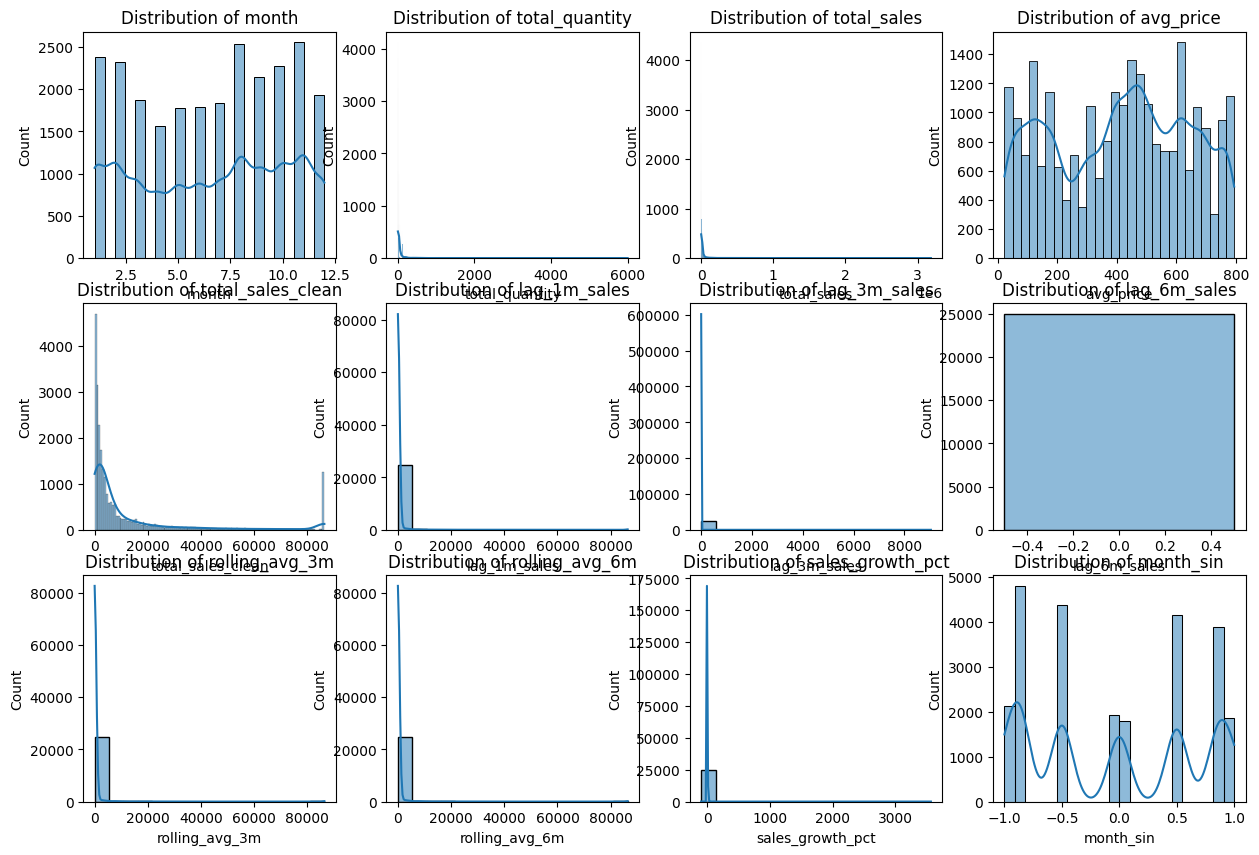

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

nums_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'year']
plt.figure(figsize=(15, 10))
for i, col in enumerate(nums_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
# Visualize distributions of numerical columns
plt.show()

# Feature Engineering

In [ ]:
pd.DataFrame(df[nums_cols])

,total_quantity,total_sales,avg_price,rolling_avg_3m_sales,sales_growth_pct
0,9.0,315.0,35.0,315.0,0.0
1,10.0,4380.0,438.0,4380.0,0.0
2,10.0,5200.0,520.0,5200.0,0.0
3,5.0,645.0,129.0,645.0,0.0
4,48.0,1680.0,35.0,1680.0,0.0
...,...,...,...,...,...
9981,4.0,2196.0,549.0,2196.0,0.0
9982,6.0,786.0,131.0,786.0,0.0
9983,10.0,330.0,33.0,330.0,0.0
9984,3.0,123.0,41.0,123.0,0.0


In [ ]:
load_from_minio("silver")

loaded pharmacy_sales_20260105_115913_4.parquet from bucket 'silver'


,distributor,customer_name,city,country,latitude,longitude,channel,sub_channel,product_name,product_class,quantity,price,sales,month,year,sales_rep_name,manager,sales_team
0,Graham and Sons,Koss Ltd Pharmaceutical Limited,Lwówek Śląski,Poland,51.1167,15.5833,Hospital,Private,Choriogestrel,Antiseptics,120.0,347.0,41640.0,June,2018,Alan Ray,James Goodwill,Alfa
1,Graham and Sons,"Beahan, Littel and Ondricka Pharmacy",Łęczyca,Poland,52.0583,19.2000,Pharmacy,Institution,Exotropin Empizine,Mood Stabilizers,150.0,785.0,117750.0,June,2018,Alan Ray,James Goodwill,Alfa
2,Graham and Sons,Streich PLC Pharmaceutical Limited,Przemyśl,Poland,49.7850,22.7673,Pharmacy,Institution,Choriotrisin,Antibiotics,700.0,591.0,413700.0,June,2018,Abigail Thompson,Tracy Banks,Bravo
3,Graham and Sons,"Buckridge, Dach and Carroll Pharmaceutical Lim...",Luboń,Poland,52.3333,16.8833,Hospital,Private,Afaxacin,Analgesics,2.0,60.0,120.0,June,2018,Erica Jones,James Goodwill,Alfa
4,Graham and Sons,"Balistreri, Torp and Gulgowski Pharmacy",Chełmża,Poland,53.2000,18.6000,Hospital,Private,Abilovir Aprotasol,Antipiretics,12.0,269.0,3228.0,June,2018,Erica Jones,James Goodwill,Alfa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Smith Inc,Herman-Koss Pharm,Lubsko,Poland,51.7877,14.9724,Hospital,Private,Afluferon Entrarenone,Antimalarial,10.0,104.0,1040.0,July,2018,Erica Jones,James Goodwill,Alfa
996,Smith Inc,Bosco-Marquardt Pharm,Lębork,Poland,54.5500,17.7500,Hospital,Private,Interfestar,Antibiotics,10.0,62.0,620.0,July,2018,Sheila Stones,Britanny Bold,Delta
997,Smith Inc,Hill Ltd,Gliwice,Poland,50.2976,18.6766,Pharmacy,Retail,Amlominphen Dexanovate,Analgesics,90.0,119.0,10710.0,July,2018,Alan Ray,James Goodwill,Alfa
998,Smith Inc,"Schowalter, Runolfsson and VonRueden Pharmaceu...",Grudziądz,Poland,53.4925,18.7761,Pharmacy,Retail,Thionide,Analgesics,10.0,113.0,1130.0,July,2018,Sheila Stones,Britanny Bold,Delta


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/miftahhadiyannoor/Library/Python/3.11/lib/python/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/Users/miftahhadiyannoor/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 302, in dispatch_control
    await self.process_control(msg)
  File "/Users/miftahhadiyannoor/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 308, in process_control
    idents, msg = self.session.feed_identities(msg, copy=False)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/miftahhadiyannoor/Library/Python/3.11/lib/python/site-packages/jupyter_client/session.py", line 994, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/miftahhadiyannoor

: 